In [5]:
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sys.path.append('../functions') # Adds the folder functions where our scripts are stored to the path
from preprocessing import img_dataset_from_dir_and_split_train_val

RSEED = 42
TRAINING_IMAGES = '../data/train/'
NUM_Classes = 39
TEST_IMAGES = ''

# 1. Load data into Keras

*Important: This notebook was created using `tensorflow-metal` on an Apple M1. On non-MX hardware, choose an api that reflects your GPU: NVIDIA (cuda) or AMD (ROCm).*

In [15]:
# This function is commented out by default. If you train multiple models or change values on the go 
# it's good practice to clear the keras session cache from time to time. 
# This helps avoid clutter from old models
'''
K.clear_session()
'''

Before we can begin training our baseline model, the data has to be loaded into Keras. Luckily, we've already split our data into train and test subfolders.

In [3]:
# We create a dataset for the training data 'train_ds' and for validation data 'val_ds' at a 80:20 ratio.
# All images will also be cropped and resized to 224x224 px to comply with the pretrained model that's
# going to be used.
train_ds, val_ds = img_dataset_from_dir_and_split_train_val(TRAINING_IMAGES)

Found 76687 files belonging to 39 classes.
Using 61350 files for training.
Using 15337 files for validation.


# 2. EfficientNetB0

In [7]:
train_ds, val_ds = img_dataset_from_dir_and_split_train_val(TRAINING_IMAGES)

# load model without first input layer, since we want to create one ourselves
model = keras.applications.EfficientNetB0(
    include_top=False
)

#freezing of the weights in order not to retrain

model.trainable = False 

Found 76687 files belonging to 39 classes.
Using 61350 files for training.
Using 15337 files for validation.


In [8]:
inputs = Input(shape = (224, 224, 3)) # image size 224x224 pixels, 3 layers (RGB)

base = model(inputs)

flatten = GlobalAveragePooling2D()(base)

outputs = Dense(39, activation='softmax')(flatten)

model_enB0 = Model(inputs,outputs)

In [9]:
model_enB0.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_enB0.fit(train_ds,
          verbose=2, # how the training log should get printed 
          epochs=10,
          validation_data=val_ds)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 3. DenseNet121

DenseNet121 is a popular pre-trained Dense Convolutional Network model for image classification. We chose to work with a pre-trained model because this is much faster than to train our own model from scratch.


In [ ]:
#1. Select the convolutional base / Pre-trained network
base_model_dense = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
#2. Freeze the weights in order to not retrain the loaded pre-trained model
base_model_dense.trainable = False

In [ ]:
# 3. Create our model with pretrained network as base model
# 3.1 Input layer
inputs = Input(shape=(224,224,3))

base = base_model_dense(inputs)

flatten = GlobalAveragePooling2D()(base)

# 3.2 Output layer
outputs = Dense(39,activation='softmax')(flatten)

# 3.3 Model
model_tf_dense = Model(inputs,outputs)
model_tf_dense.summary()

In [ ]:
# 4. First, our model has to be compiled. This is some sort of precomputing so that we can then train our model
# in the next step.

# The 'tf.keras.optimizers.legacy.Adam' has to be changed to 'Adam' if not running on an MX Mac computer!

# 4.1 Compile model
model_tf_dense.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4.2 Then we fit the model. This is where the training takes place.
history = model_tf_dense.fit(train_ds,
          #verbose=2, # how much of the training log should get printed 
          epochs=10,
          validation_data=val_ds)

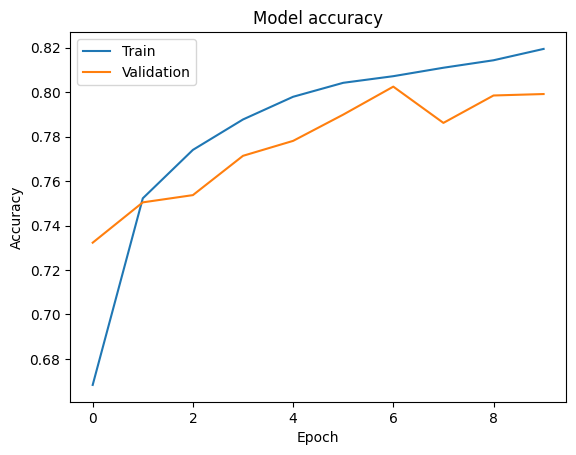

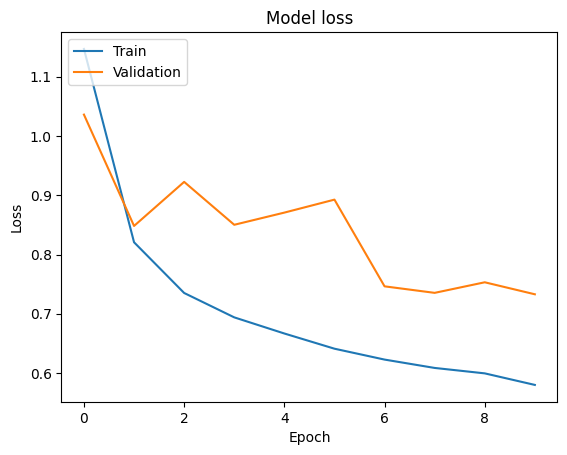

In [36]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Follwing is the example code for different pre-trained models.

# 4. ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model without the top layer (include_top=False)
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the ResNet model
for layer in base_model_resnet.layers:
    layer.trainable = False

# Add a fully connected layer on top of the ResNet model
x = Flatten()(base_model_resnet.output)
x = Dense(256, activation='relu')(x)
output = Dense(NUM_Classes, activation='softmax')(x)

# Create the custom model
model = Model(inputs=base_model_resnet.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train_data_directory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'validation_data_directory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

# Train the model
model.fit(
        train_generator,
        steps_per_epoch=2000 // 32,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=800 // 32)

# Make predictions
predictions = model.predict(TEST_IMAGES)


# 5. VGG16

In [ ]:

from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add a fully connected layer on top of the VGG16 model
x = Flatten()(base_model_vgg16.output)
x = Dense(256, activation='relu')(x)
output = Dense(NUM_Classes, activation='softmax')(x)

# Create the custom model
model = Model(inputs=base_model_vgg16.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train_data_directory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'validation_data_directory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

# Train the model
model.fit(
        train_generator,
        steps_per_epoch=2000 // 32,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=800 // 32)

# Make predictions
predictions = model.predict(TEST_IMAGES)


# 6. InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load the pre-trained InceptionV3 model
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the InceptionV3 model
for layer in base_model_inception.layers:
    layer.trainable = False

# Add a fully connected layer on top of the InceptionV3 model
x = Flatten()(base_model_inception.output)
x = Dense(256, activation='relu')(x)
output = Dense(NUM_Classes, activation='softmax')(x)

# Create the custom model
model = Model(inputs=base_model_inception.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train_data_directory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'validation_data_directory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

# Train the model
model.fit(
        train_generator,
        steps_per_epoch=2000 // 32,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=800 // 32)

# Make predictions
predictions = model.predict(TEST_IMAGES)


# 7. Xception

In [ ]:
from tensorflow.keras.applications import Xception

# Load the pre-trained Xception model
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the Xception model
for layer in base_model_xception.layers:
    layer.trainable = False

# Add a fully connected layer on top of the Xception model
x = Flatten()(base_model_xception.output)
x = Dense(256, activation='relu')(x)
output = Dense(NUM_Classes, activation='softmax')(x)

# Create the custom model
model = Model(inputs=base_model_xception.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train_data_directory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'validation_data_directory',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

# Train the model
model.fit(
        train_generator,
        steps_per_epoch=2000 // 32,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=800 // 32)

# Make predictions
predictions = model.predict(TEST_IMAGES)
